In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
%matplotlib inline
import warnings

sns.set(style="darkgrid")

data = pd.read_csv("BlackFriday.csv")
data.head(4)


,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057


In [2]:
data = data.fillna(0)
data_numeric = data[["User_ID", "Product_Category_1", "Product_Category_2", "Product_Category_3", "Purchase"]].groupby("User_ID").sum().reset_index().drop("User_ID", axis=1)
data_categoric = data.drop_duplicates("User_ID")[["User_ID", "Gender", "Age", "Occupation","City_Category", "Stay_In_Current_City_Years", "Marital_Status"]].reset_index().drop(["index"], axis=1)
data = pd.concat([data_categoric, data_numeric], axis=1)
data[["Product_Category_2", "Product_Category_3"]] = data[["Product_Category_2", "Product_Category_3"]].astype("int64")
data.tail(5)

,User_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
5886,1004588,F,26-35,4,C,0,0,2926,3166,1379,3821666
5887,1004871,M,18-25,12,C,2,0,886,837,443,1075037
5888,1004113,M,36-45,17,C,3,0,58,93,51,80859
5889,1005391,M,26-35,7,A,0,0,382,522,286,554504
5890,1001529,M,18-25,4,C,4+,1,1087,1070,405,1562615


Text(0.5, 1.0, 'Correlation between features')

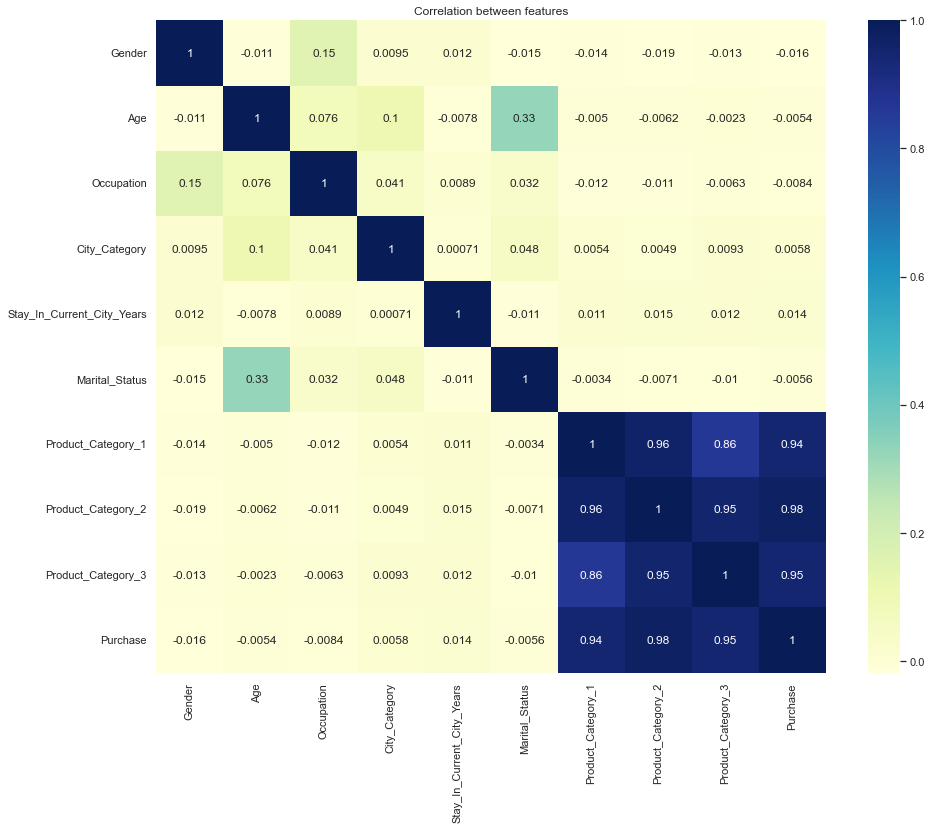

In [3]:
# label encoding: categorical to numeric
le = preprocessing.LabelEncoder()
cat_col = data.select_dtypes(include="object").columns.tolist()
for i in cat_col:
    data.loc[:, i] = le.fit_transform(data.loc[:, i])
    
fig, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(data.drop("User_ID", axis=1).corr(), annot=True, cmap="YlGnBu").set_title("Correlation between features")

In [4]:
predictor = data.drop("Purchase", axis=1)
target = data["Purchase"]

# find the best parameter for model making
param_grid = {"n_estimators":[1, 5, 10, 50, 100, 150, 300, 500], \
              "max_depth":[1, 3, 5, 7, 9]}
grid_rf = GridSearchCV(RandomForestRegressor(), param_grid, cv=5, scoring="neg_mean_squared_error").fit(predictor, target)
print("Best parameter: {}".format(grid_rf.best_params_))
print("Best score: {:.2f}".format((-1*grid_rf.best_score_)**0.5))

Best parameter: {'max_depth': 9, 'n_estimators': 300}
Best score: 193785.00


In [5]:
# make model with best parameters
model = RandomForestRegressor(n_estimators=500, max_depth=9, random_state=1, verbose=1)


# predict with cross validation
scores = cross_val_score(model, predictor, target, scoring="explained_variance", cv=5)
print(scores)
print("Model effectiveness: %f" % (scores.mean()))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    6.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    6.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    6.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[0.95295525 0.95990488 0.95791431 0.953862   0.95914217]
Model effectiveness: 0.956756


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    5.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished


In [6]:
import pickle

filename = 'modelTest.sav'
pickle.dump(model, open(filename, 'wb'))